In [1]:
import numpy as np
import random 
from scipy.stats import unitary_group
from scipy.sparse import csr_matrix, kron
from itertools import combinations

import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [13]:

# Define CNOT gate (control=0, target=1)
CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=complex)

def generate_matchings(qubits):
    if not qubits:
        return [[]]
    matchings = []
    first = qubits[0]
    for i in range(1, len(qubits)):
        pair = (first, qubits[i])
        rest = qubits[1:i] + qubits[i+1:]
        for submatching in generate_matchings(rest):
            matchings.append([pair] + submatching)
    return matchings
# Debugged using ChatGPT
def apply_cnot_matrix_on_nqubits(control, target, n):
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])

    result = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(2**n):
        b = list(np.binary_repr(i, width=n))
        #b = list(f"{i:0{n}b}")
        if b[control] == '1':
            if b[target] == '1':
                b[target] = '0' 
            else:
                b[target] = '1'
        #j = int(''.join(b), 2)
        j = int(''.join(str(bit) for bit in b), 2)
        result[j, i] = 1
    return csr_matrix(result)

def build_cnot_matrix_for_matching(matching, n=6):
    U = csr_matrix(np.eye(2**n, dtype=complex))
    for control, target in matching:
        U = apply_cnot_matrix_on_nqubits(control, target, n) @ U
    return U

qubits = list(range(6))
matchings = generate_matchings(qubits)
# Sort matchings for consistency suggested by CHatGPT
matchings = [sorted([tuple(sorted(pair)) for pair in m]) for m in matchings]
matchings = sorted(matchings)
#matchings =[[(0,1),(2,3),(4,5)],[(0,3),(1,4),(2,5)],[(0,5),(1,3),(2,4)],[(0,2),(1,5),(3,4)],[(0,4),(1,2),(3,5)]]
CNOTS = [build_cnot_matrix_for_matching(m) for m in matchings]
print(len(CNOTS))
print(matchings)

15
[[(0, 1), (2, 3), (4, 5)], [(0, 1), (2, 4), (3, 5)], [(0, 1), (2, 5), (3, 4)], [(0, 2), (1, 3), (4, 5)], [(0, 2), (1, 4), (3, 5)], [(0, 2), (1, 5), (3, 4)], [(0, 3), (1, 2), (4, 5)], [(0, 3), (1, 4), (2, 5)], [(0, 3), (1, 5), (2, 4)], [(0, 4), (1, 2), (3, 5)], [(0, 4), (1, 3), (2, 5)], [(0, 4), (1, 5), (2, 3)], [(0, 5), (1, 2), (3, 4)], [(0, 5), (1, 3), (2, 4)], [(0, 5), (1, 4), (2, 3)]]


In [3]:
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

# defining rotation gates
def Ry(A):
    sn, cs = np.sin(A/2), np.cos(A/2)
    M = np.array([[cs,-sn],[sn, cs]])
    return M
def Rz(A):
    phi = np.exp(-1j*A/2)
    M = np.array([[phi,0],[0,np.conj(phi)]])
    return M
    
#Returns a length-2 array instead of 2x2 matrix. Faster, since it's diagonal. Good for Z rotations!
def Rz2(A):
    phi = np.exp(-1j*A/2)
    return np.array([phi, np.conj(phi)])
    
def Rz2t(A):
    phi = np.exp(-1j*A/2)
    return np.array([[phi], [np.conj(phi)]])

Z2 = np.array([1,-1])
Z2t = np.array([[1],[-1]])
    
# Parameterising the general unitary with rotation gates
def U(A0,A1,A2): # Arguments: Euler Angles
    M = Rz2t(A1) * Ry(A0) * Rz2(A2)
    return M

# derivatives wrt A0,A1,A2
def DA0(A0,A1,A2):
    dA0 = (-1j/2)*(Rz(A1)@Y@Ry(A0)@Rz(A2))
    return dA0
def DA1(A0,A1,A2):
    dA1 = (-1j/2)*(Z@Rz(A1)@Ry(A0)@Rz(A2))
    return dA1
def DA2 (A0,A1,A2):
    dA2 = (-1j/2)*(Rz(A1)@Ry(A0)@Z@Rz(A2))
    return dA2

#Compute U and all three derivatives together, to save computation
def DA_all(A0,A1,A2):
    R1 = Rz2t(A1)
    R0 = Ry(A0)
    R2 = Rz2(A2)
    R02 = R0 * R2
    R102 = R1 * R02
    U = R102
    dA0 = (-0.5j) * R1 * (Y @ R02)
    dA1 = (-0.5j) * Z2t * R102
    dA2 = (-0.5j) * R102 * Z2
    return (U, dA0, dA1, dA2)

# defining inverse
def inverse(M):
    M_inverse = M.transpose().conjugate()
    return M_inverse
    
def parameters(layers): # layers = number of unitary layers, so no-of CNOTs = layers - 1
    A = np.zeros((6*layers,3))
    for i in range(6*layers):
        for j in range(3):
            A[i][j] = random.uniform(0.0, 4*np.pi) 
    return A
    
def Ulist(layers, A):
    U_list=[]
    for i in range(6*layers):
        Ui = U(A[i][0],A[i][1],A[i][2])
        U_list.append(Ui)
    return U_list

#Get the unitary created by these four single-qubit unitaries at layer i.
def U_6squ(A, i):
    U1 = U(A[6*i  ][0],A[6*i  ][1],A[6*i  ][2])
    U2 = U(A[6*i+1][0],A[6*i+1][1],A[6*i+1][2])
    U3 = U(A[6*i+2][0],A[6*i+2][1],A[6*i+2][2])
    U4 = U(A[6*i+3][0],A[6*i+3][1],A[6*i+3][2])
    U5 = U(A[6*i+4][0],A[6*i+4][1],A[6*i+4][2])
    U6 = U(A[6*i+5][0],A[6*i+5][1],A[6*i+5][2])
    return np.kron(np.kron(np.kron(U1, U2), np.kron(U3, U4)), np.kron(U5,U6))

#Like `U_6squ` - But, optionally, skip the single unitary labelled j.
def U_6squ_skip(A, i, j):
    U1 = np.eye(2) if 6*i   == j else U(A[6*i  ][0],A[6*i  ][1],A[6*i  ][2])
    U2 = np.eye(2) if 6*i+1 == j else U(A[6*i+1][0],A[6*i+1][1],A[6*i+1][2])
    U3 = np.eye(2) if 6*i+2 == j else U(A[6*i+2][0],A[6*i+2][1],A[6*i+2][2])
    U4 = np.eye(2) if 6*i+3 == j else U(A[6*i+3][0],A[6*i+3][1],A[6*i+3][2])
    U5 = np.eye(2) if 6*i+4 == j else U(A[6*i+4][0],A[6*i+4][1],A[6*i+4][2])
    U6 = np.eye(2) if 6*i+5 == j else U(A[6*i+5][0],A[6*i+5][1],A[6*i+5][2])

    return np.kron(np.kron(np.kron(U1, U2), np.kron(U3, U4)), np.kron(U5,U6))

#Given a 1-qubit unitary Ui on site s (0-5), expand it to a 6-qubit unitary.
def expand_on_site(Ui, s):
    if s == 0:
        return np.kron(Ui, np.eye(32))
    elif s == 1:
        return np.kron(np.eye(2), np.kron(Ui, np.eye(16)))
    elif s == 2:
        return np.kron(np.eye(4), np.kron(Ui, np.eye(8)))
    elif s == 3:
        return np.kron(np.eye(8), np.kron(Ui, np.eye(4)))
    elif s == 4:
        return np.kron(np.eye(16), np.kron(Ui, np.eye(2)))
    elif s == 5:
        return np.kron(np.eye(32), Ui)
    
#Like `U_4squ`, but it's only the unitary at the one site j. That is, it's the single-qubit
#unitary, but expanded to 4-qubits.
def U_6squ_only(A, j):
    # i = j // 4
    # U1 = np.eye(2) if 4*i   != j else U(A[4*i  ][0],A[4*i  ][1],A[4*i  ][2])
    # U2 = np.eye(2) if 4*i+1 != j else U(A[4*i+1][0],A[4*i+1][1],A[4*i+1][2])
    # U3 = np.eye(2) if 4*i+2 != j else U(A[4*i+2][0],A[4*i+2][1],A[4*i+2][2])
    # U4 = np.eye(2) if 4*i+3 != j else U(A[4*i+3][0],A[4*i+3][1],A[4*i+3][2])
    # return np.kron(np.kron(U1, U2), np.kron(U3, U4))
    return expand_on_site(U(A[j][0],A[j][1],A[j][2]), j % 6)
    
#Construct the unitary for the circuit parameterized by "A".
def make_circuit(A, layers):
    U = np.eye(64)
    for i in range(layers-1): #layers-1, because we don't do a CNOT at the end
        U = U @ U_6squ(A, i) @ CNOTS[i%5]
    U = U @ U_6squ(A, layers-1)
    return U

#Measure the error between the circuit parameterized by "A" and U_goal.
def get_error(A, layers, U_goal):
    U = make_circuit(A, layers)
    Tr = np.trace(U @ inverse(U_goal))
    Abs = np.abs(Tr)
    Uerr = 64 - Abs
    return Uerr

def circuit_structure(A, layers, j, U_goal): # qubit number    
    q = (j-1) // 6
    Uf = np.eye(64)
    Ub = np.eye(64)
    for it in range(q):
        Uf = Uf @ U_6squ(A, it) @ CNOTS[it%5]
    Uf = Uf @ U_6squ_skip(A, q, j-1)
    for ib in range(q+1, layers):
        Ub = Ub @ CNOTS[(ib-1)%5] @ U_6squ(A, ib)
    U_tbm = inverse(Uf) @ U_goal @ inverse(Ub) # U_tbm = rhs , U to be made
    return U_tbm

#The trace inner product of two matrices. Equal to np.trace(A @ inverse(B)), but faster
def trace_prod_inv(A, B):
    # return np.trace(A @ inverse(B))
    return np.conj(np.vdot(A, B))


In [4]:
#Replaces computing the gradient + gradual adjustment, with just rounding each goal directly to its nearest unitary
#and using that. Note: no "alpha" for learning rate anymore.
def gradient_descent3(layers,U_goal, A, iterations):
    nsu = 6*layers #(number of single qubit unitaries)
    #inner_iterations = int(iterations/10)
    #print(inner_iterations)
    stop_flag=0
    Uerr_array = []

    for i in range(iterations):
        if i%10==0:
            print("iteration",i)
        if stop_flag ==1:
            print("Truncation")
            break

        #Kepp running track of the error: inverse(Uf) * U_goal * inverse(Ub). We'll update this dynamically.
        Ub = U_6squ(A, 0)
        for l in range(1, layers):
            Ub = Ub @ CNOTS[(l-1)%5] @ U_6squ(A, l)
        Ui_err = U_goal @ inverse(Ub)
            
        for l in range(0, layers):            
            for s in [0,1,2,3,4,5]:
                j = 6*l+s
                
                # RHS
                Ui_err = Ui_err @ U_6squ_only(A, j)

                #check how to generalise partial trace
                #Compute the partial trace of Ui, to leave just the `s` qubit part
                if s == 0:
                    Ui2 = np.trace(Ui_err.reshape(2,32, 2,32), axis1=1, axis2=3)
                
                elif s == 1:
                    Ui2 = Ui_err.reshape(2,2,16, 2,2,16)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)  # trace over qubit 0
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3)  # trace over qubit 1 (axes shifted)
                
                elif s == 2:
                    Ui2 = Ui_err.reshape(4,2,8, 4,2,8)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)  # trace over qubit 0
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3)  # trace over qubit 1
                
                elif s == 3:
                    Ui2 = Ui_err.reshape(8,2,4, 8,2,4)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)  # trace over qubit 0
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3) 
                
                elif s == 4:
                    Ui2 = Ui_err.reshape(16,2,2, 16,2,2)
                    Ui2 = np.trace(Ui2, axis1=0, axis2=3)  # trace over qubit 0
                    Ui2 = np.trace(Ui2, axis1=1, axis2=3) 
                
                elif s == 5:
                    Ui2 = np.trace(Ui_err.reshape(32,2, 32,2), axis1=0, axis2=2)  # trace over qubit 5

                #Round goal to nearest unitary
                svd = np.linalg.svd(Ui2)
                unitized = svd[0] @ svd[2]
                unitized /= np.sqrt(np.linalg.det(unitized)) #Convert from U(2) to SU(2)

                # Get Euler angles
                beta = 2 * np.arctan(np.abs(unitized[1][0] / unitized[0][0]))
                phia = np.angle(unitized[0][0])
                phib = np.angle(unitized[1][0])
                a = phib - phia
                c = -(phia + phib)
                
                A[j][0]=beta
                A[j][1]=a
                A[j][2]=c
                
                #computing cost function
                # Uk = U(A0,A1,A2)
                Uk = unitized
                Tr = trace_prod_inv(Ui2, unitized)
                Abs = np.abs(Tr)
                Uerr = 64 - Abs
                if Uerr < 1e-8:
                    stop_flag=1
                    break
                #Uerr_array.append(Uerr)
                #print(np.shape(unitized))
                Ui_err = inverse(expand_on_site(unitized, s)) @ Ui_err
               
            Ui_err = CNOTS[l%5] @ Ui_err @ CNOTS[l%5]
            if stop_flag==1:
                break
        Uerr_array.append(Uerr) 
            
    return Uerr_array
    #return Aopt, stop_flag

Different layers

In [39]:
layers = 100
U_goal = (unitary_group.rvs(64))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
#print("Initialisation:")
Uerr = gradient_descent3(layers,U_goal, AOpt, 2000)

    

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite


Iterations: 2000
Final error: 1.1982899978830923


Text(0.5, 1.0, 'Different layers - 100')

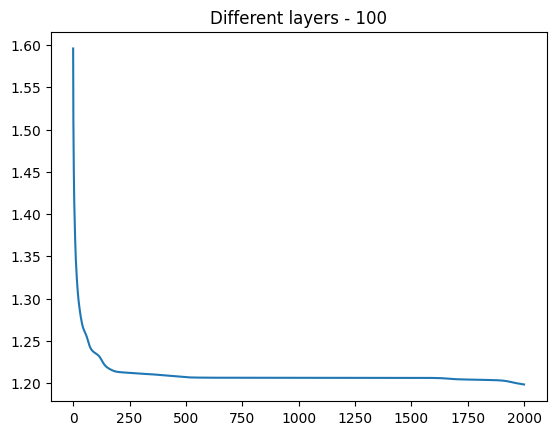

In [40]:
np.save('6_qubit_system_difflayers_100.npy', Uerr)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
plt.plot(np.log10(Uerr))
plt.title("Different layers - 100")
#plt.savefig("342 new")
#plt.close()

In [41]:
layers = 200
U_goal = (unitary_group.rvs(64))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
#print("Initialisation:")
Uerr = gradient_descent3(layers,U_goal, AOpt, 3000)


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite


Iterations: 3000
Final error: 0.44564256612684844


Text(0.5, 1.0, 'Different layers - 200')

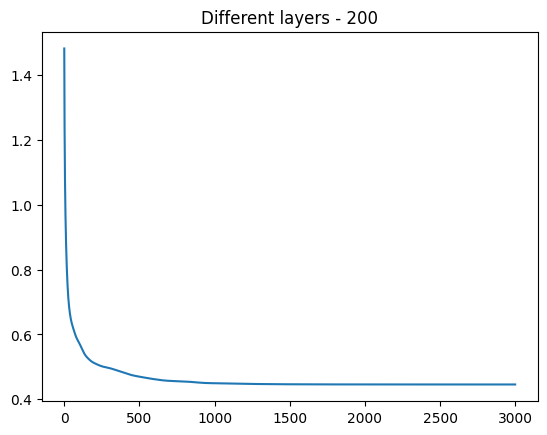

In [42]:
np.save('6_qubit_system_difflayers_200.npy', Uerr)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
plt.plot(np.log10(Uerr))
plt.title("Different layers - 200")

In [43]:
layers = 300
U_goal = (unitary_group.rvs(64))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
#print("Initialisation:")
Uerr = gradient_descent3(layers,U_goal, AOpt, 7500)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite


Iterations: 7500
Final error: -1.21239531710596


Text(0.5, 1.0, 'Different layers - 300')

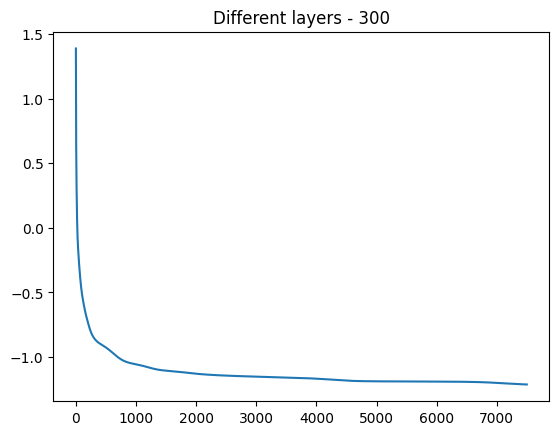

In [44]:
np.save('6_qubit_system_difflayers_300.npy', Uerr)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
plt.plot(np.log10(Uerr))
plt.title("Different layers - 300")

In [45]:
layers = 320
U_goal = (unitary_group.rvs(64))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
#print("Initialisation:")
Uerr = gradient_descent3(layers,U_goal, AOpt, 10000)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite


Iterations: 10000
Final error: -2.034390028207018


Text(0.5, 1.0, 'Different layers - 320')

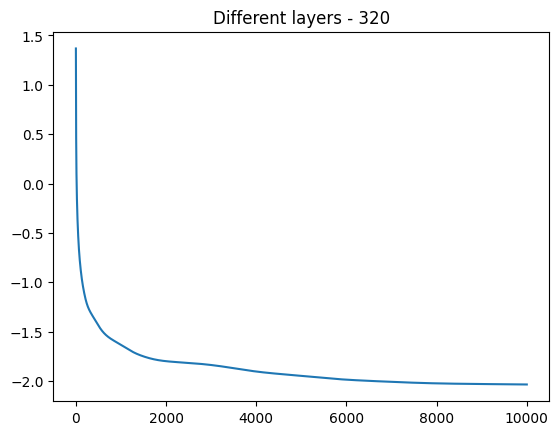

In [46]:
np.save('6_qubit_system_difflayers_320.npy', Uerr)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
plt.plot(np.log10(Uerr))
plt.title("Different layers - 320")

In [7]:
layers = 350
U_goal = (unitary_group.rvs(64))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
#print("Initialisation:")
Uerr = gradient_descent3(layers,U_goal, AOpt, 20000)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite


Iterations: 8281
Final error: -8.000001198407125


Text(0.5, 1.0, 'Different layers - 350')

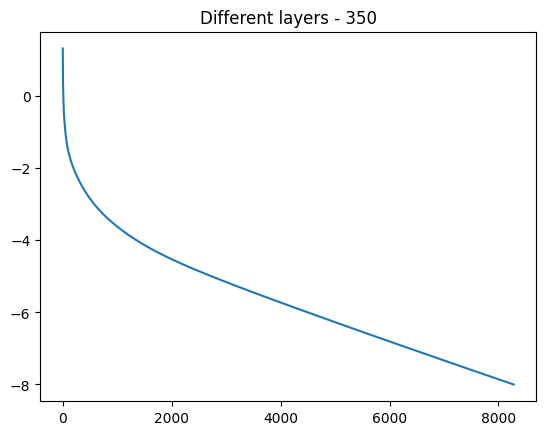

In [8]:
np.save('6_qubit_system_difflayers_350.npy', Uerr)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
plt.plot(np.log10(Uerr))
plt.title("Different layers - 350")

In [9]:
layers = 370
U_goal = (unitary_group.rvs(64))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
#print("Initialisation:")
Uerr = gradient_descent3(layers,U_goal, AOpt, 20000)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite


Iterations: 1252
Final error: -8.000001506992875


Text(0.5, 1.0, 'Different layers - 370')

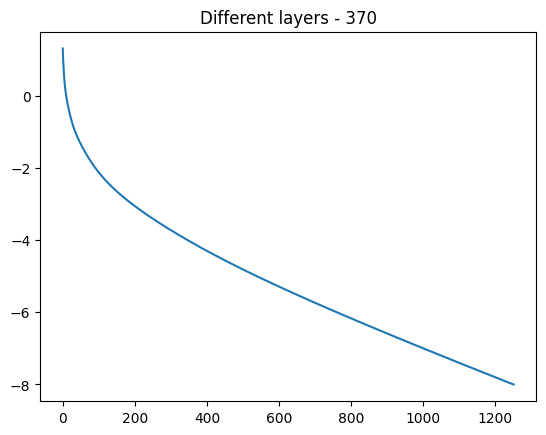

In [10]:
np.save('6_qubit_system_difflayers_370.npy', Uerr)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
plt.plot(np.log10(Uerr))
plt.title("Different layers - 370")

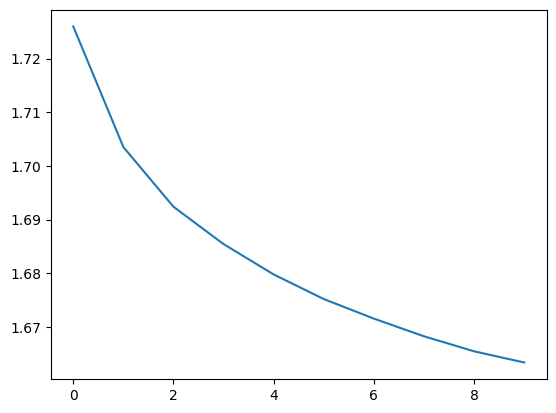

In [17]:
np.save('layers_300.npy', Uerr)
loaded_data = np.load('layers_300.npy')
plt.plot(np.log10(loaded_data))

# Different Unitaries

In [7]:
load1 =np.load('6_qubit_diffunitaries_Uerrl_0.npy')
load2 =np.load('6_qubit_diffunitaries_Uerrl_1.npy')
load3 =np.load('6_qubit_diffunitaries_Uerrl_8.npy')
load4 =np.load('6_qubit_diffunitaries_Uerrl_4.npy')
load5 =np.load('6_qubit_diffunitaries_Uerrl_7.npy')
plt.plot(load1, label = "Unitary-1")
plt.plot(load2, label = "Unitary-2")
plt.plot(load3, label = "Unitary-3")
plt.plot(load4, label = "Unitary-4")
plt.plot(load5, label = "Unitary-5")
plt. xlabel('Iterations')
plt.ylabel('C($ \Theta, \phi, \lambda)$')
plt.ylim(1e-8,1e2)
plt.legend()
plt.yscale('log')
plt.savefig('6 qubit system diffunitaries')
plt.close()

<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
C:\Users\jrajagopal\AppData\Local\Temp\ipykernel_18952\3330205093.py:12: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('C($ \Theta, \phi, \lambda)$')


# Different Initializations


In [9]:
load1 =np.load('6_qubit_diffinit_Uerrl_0.npy')
load2 =np.load('6_qubit_diffinit_Uerrl_1.npy')
load3 =np.load('6_qubit_diffinit_Uerrl_2.npy')
load4 =np.load('6_qubit_diffinit_Uerrl_3.npy')
load5 =np.load('6_qubit_diffinit_Uerrl_4.npy')
plt.plot(load1, label = "Initialization-1")
plt.plot(load2, label = "Initialization-2")
plt.plot(load3, label = "Initialization-3")
plt.plot(load4, label = "Initialization-4")
plt.plot(load5, label = "Initialization-5")
plt. xlabel('Iterations')
plt.ylabel('C($ \Theta, \phi, \lambda)$')
plt.ylim(1e-8,1e2)
plt.legend()
plt.yscale('log')
plt.savefig('6 qubit system diffinit')
plt.close()

<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
C:\Users\jrajagopal\AppData\Local\Temp\ipykernel_18952\2069337422.py:12: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('C($ \Theta, \phi, \lambda)$')


# Different Layers

In [12]:
load1 = np.load('6_qubit_system_difflayers_100.npy')
load2 = np.load('6_qubit_system_difflayers_200.npy')
load3 = np.load('6_qubit_system_difflayers_300.npy')
load4 = np.load('6_qubit_system_difflayers_320.npy')
load5 =np.load('6_qubit_diffinit_Uerrl_4.npy')
load6 = np.load('6_qubit_system_difflayers_350.npy')
load7 = np.load('6_qubit_system_difflayers_370.npy')
plt.plot(load1, label = "100 layers")
plt.plot(load2, label = "200 layers")
plt.plot(load3, label = "300 layers")
plt.plot(load4, label = "320 layers")
plt.plot(load5, label = "342 layers")
plt.plot(load6, label="350 layers")
plt.plot(load7, label="370 layers")
plt. xlabel('Iterations')
plt.ylabel('C($ \Theta, \phi, \lambda)$')
plt.ylim(1e-8,1e2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig('6 qubit system different layers')
plt.close()

<>:16: SyntaxWarning: invalid escape sequence '\T'
<>:16: SyntaxWarning: invalid escape sequence '\T'
C:\Users\jrajagopal\AppData\Local\Temp\ipykernel_18952\2111021060.py:16: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel('C($ \Theta, \phi, \lambda)$')
